<a href="https://colab.research.google.com/github/Anth-us/semantic-text-classification/blob/main/Custom_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Using Logistic Regression and Vector Embeddings

### Objective
This notebook aims to develop and evaluate a logistic regression model for classifying sentences. The model will identify whether a sentence is related to the Spanish immigration system.

### Methodology
- We utilize vector embeddings obtained from the OpenAI Ada 2 model.
- A logistic regression approach is employed for the classification task.

### Data
- The dataset comprises synthetic sentences, some related to Spanish immigration and others not.
- We split the data into training and evaluation sets for a robust assessment.

### Evaluation
- The model's performance is evaluated using metrics such as accuracy, precision, recall, and F1-score.
- A confusion matrix will provide insights into the model's classification capabilities.

### Visualization
- The notebook will feature visualizations, including static plots and dynamic animations, to illustrate the training and evaluation process.

## Import necessary libraries

In [1]:
!pip install gensim
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [2]:
import time
import json
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import requests
from openai import OpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import userdata

## Generate the embeddings

We'll convert each sentence in our dataset into a vector embedding. We'll load our initial CSV file, which contains sentences and their associated labels, we'll compute an embedding for each sentence, and we'll store that back to a CSV file that includes the label, sentence and embedding.  We'll do that in a few different ways.

### OpenAI Ada 2

In [3]:
client = OpenAI(api_key=userdata.get('openai'))

# Initialize counters
counter = 0
token_count = 0

# Function to get embeddings from OpenAI
def get_embedding(sentence):
    global token_count, counter
    try:
        response = client.embeddings.create(
            model="text-embedding-ada-002",
            input=sentence
        )

        # Extract the embedding and convert it to JSON string
        embedding = response.model_dump()['data'][0]['embedding']

        # Update token count
        if 'usage' in response.model_dump():
            token_count += response.model_dump()['usage']['total_tokens']

        # Print only for the first 10 sentences
        if counter < 3:
            print("Embedding: ", embedding)
            print("token_count: ", token_count)
        elif counter == 3:
            print("Continuing to process, but not printing the rest...")

        counter += 1
        return json.dumps(embedding)
    except Exception as e:
        print(f"Error in processing sentence: '{sentence}'. Error: {e}")
        return None  # or a default embedding

# Load the CSV containing labeled sentences
df = pd.read_csv('labeled.csv')

# Generate embeddings for each sentence
start_time = time.time()
df['embedding'] = df['sentence'].apply(get_embedding)
end_time = time.time()

total_time_ms = (end_time - start_time) * 1000
print(f"Total time taken for batch: {total_time_ms} ms")

# Print total token count
print(f"Total token count: {token_count}")

# Calculate cost
price_per_1k_tokens = 0.0001  # $0.0001 per 1K tokens
cost = (token_count / 1000) * price_per_1k_tokens
print(f"Total cost for {token_count} tokens: ${cost:.4f}")

ada2_cost = cost
ada2_time = total_time_ms

# Row counter for limiting output.
counter = 0

# Save to new CSV
df.to_csv('Ada 2.csv', index=False)


Embedding:  [0.019655795767903328, -0.004800185561180115, 0.03021051734685898, -0.020452139899134636, -0.03177792578935623, 0.0014710245886817575, -0.025799022987484932, -0.00022792191884946078, -0.020907195284962654, -0.022525163367390633, 0.01030191220343113, 0.0025944386143237352, 0.01252662017941475, 0.02024989388883114, -0.005365842953324318, 0.013133358210325241, 0.026039190590381622, -0.023966167122125626, 0.058297447860240936, -0.0012166369706392288, -0.03385094553232193, 0.007691673468798399, -0.01629345491528511, -0.005545968189835548, 0.00914531759917736, 0.0016369296936318278, 0.018101029098033905, -0.008709223940968513, -0.004541057627648115, -0.01969371736049652, 0.033092524856328964, -0.0006035782862454653, -0.0003509681555442512, 0.0013943923404440284, -0.022891733795404434, -0.005015071947127581, -0.009789977222681046, -0.01593952439725399, 0.017292045056819916, -0.001750693074427545, 0.02471194975078106, 0.02659536711871624, -0.005836697295308113, 0.002482255222275853

## BERT

In [4]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embedding(sentence):
    global counter

    # Tokenize and encode the sentence
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the mean of the last hidden state as the sentence embedding
    sentence_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    # Convert array to JSON string
    sentence_emb_json = json.dumps(sentence_emb.tolist())

    if counter < 3:
        print("Embedding: ", sentence_emb_json)
    elif counter == 3:
        print("Continuing to process, but not printing the rest...")

    counter += 1
    return sentence_emb_json

# Reset counter
counter = 0

# Generate embeddings
start_time = time.time()
df['embedding'] = df['sentence'].apply(bert_embedding)
end_time = time.time()

total_time_ms = (end_time - start_time) * 1000
print(f"Total time taken for batch: {total_time_ms} ms")

# There is no API cost.
print(f"Total token count: 0")

BERT_cost = 0
BERT_time = total_time_ms

# Save to new CSV
df.to_csv('BERT.csv', index=False)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding:  [-0.23313181102275848, -0.30737432837486267, -0.17015017569065094, 0.12677490711212158, 0.6584125757217407, 0.2631322741508484, 0.14025580883026123, 1.3568280935287476, 0.16707292199134827, -0.2427053153514862, -0.1555050015449524, -0.24177873134613037, -0.09613368660211563, 0.16425980627536774, -0.19912798702716827, 1.1140857934951782, 0.6899012327194214, -0.08486225455999374, -0.48404189944267273, 0.10067449510097504, 0.2901366949081421, -0.41568779945373535, -0.004370814189314842, 0.09828056395053864, -0.2090129852294922, -0.5960085391998291, -0.27324527502059937, 0.24805618822574615, -0.3375166356563568, -0.1054101437330246, -0.088280588388443, -0.12534384429454803, -0.8349630236625671, -0.10627224296331406, 0.43717846274375916, 0.40268784761428833, 0.055624376982450485, -0.5566353797912598, -0.1431456208229065, 0.3612031936645508, -0.8249363899230957, -0.22906775772571564, -0.42001792788505554, 0.006165876053273678, -0.2771264314651489, -0.15688566863536835, 0.33307048

### Word2Vec

In [5]:
# Prepare sentences for Word2Vec
sentences = [sentence.split() for sentence in df['sentence']]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=150, window=5, min_count=1, workers=4)

# Initialize a counter
counter = 0

# Function to generate sentence embedding by averaging word embeddings
def sentence_embedding(sentence):
    global counter

    words = sentence.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    sentence_emb = np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)

    # Convert array to JSON string
    sentence_emb_json = json.dumps(sentence_emb.tolist())

    # Print only for the first 10 sentences
    if counter < 3:
        print("Embedding: ", sentence_emb_json)
    elif counter == 3:
        print("Continuing to process, but not printing the rest...")

    counter += 1
    return sentence_emb_json

# Generate embeddings
start_time = time.time()
df['embedding'] = df['sentence'].apply(sentence_embedding)
end_time = time.time()

total_time_ms = (end_time - start_time) * 1000
print(f"Total time taken for batch: {total_time_ms} ms")

# There is no API cost.
print(f"Total token count: 0")

word2vec_cost = 0
word2vec_time = total_time_ms

# Save to new CSV
df.to_csv('Word2Vec.csv', index=False)

Embedding:  [0.04166720062494278, -0.02483900636434555, -0.04720514267683029, -0.12616406381130219, -0.03470058739185333, -0.1745377629995346, -0.06989723443984985, 0.3815528452396393, -0.16242216527462006, 0.13047078251838684, 0.1520015001296997, -0.05854974314570427, -0.23530027270317078, 0.3134254515171051, -0.1543070375919342, -0.028867240995168686, 0.2305912971496582, 0.12915894389152527, 0.017087435349822044, 0.1415713131427765, -0.1879153996706009, -0.06767691671848297, 0.11390542984008789, 0.2241639792919159, -0.0036127690691500902, -0.04690765216946602, -0.283441960811615, -0.03075573965907097, 0.06356181204319, -0.3307058811187744, 0.016989482566714287, 0.016250718384981155, -0.02730412408709526, 0.018935637548565865, -0.17597365379333496, 0.05270323157310486, 0.40517836809158325, 0.06009731441736221, -0.01686153933405876, -0.1767469346523285, 0.07872237265110016, 0.06382275372743607, -0.06584922969341278, -0.12132030725479126, 0.1375230848789215, 0.04111677408218384, 0.05017

## Load and preprocess data

Assume you have a DataFrame df with two columns: sentence (text data) and label (0 or 1, indicating whether the sentence is about Spanish immigration).

In [6]:
# List of filenames for different embedding CSVs
filenames = [
    'Ada 2.csv',
    'BERT.csv',
    'Word2Vec.csv'
  ]

def prepare_data(filename):
    df = pd.read_csv(filename)
    X, y = [], []

    for idx, row in df.iterrows():
        try:
            # Convert string to list if necessary
            embedding = json.loads(row['embedding']) if isinstance(row['embedding'], str) else row['embedding']
            X.append(embedding)
            y.append(row['label'])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in row {idx} of file {filename}: {e}")
            print(f"Faulty data: {row['embedding']}")
        except Exception as e:
            print(f"Unexpected error in row {idx} of file {filename}: {e}")

    return np.array(X), np.array(y)

# Dictionary to store the X and y for each embedding type
data_for_embeddings = {}

for filename in filenames:
    print(f"Processing file: {filename}")
    X, y = prepare_data(filename)
    data_for_embeddings[filename] = (X, y)
    print(f"Completed processing file: {filename}\n")

Processing file: Ada 2.csv
Completed processing file: Ada 2.csv

Processing file: BERT.csv
Completed processing file: BERT.csv

Processing file: Word2Vec.csv
Completed processing file: Word2Vec.csv



## Split data into training and testing sets

In [7]:
# Dictionary to store train-test splits for each embedding type
train_test_splits = {}

for filename, (X, y) in data_for_embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_test_splits[filename] = (X_train, X_test, y_train, y_test)
    print(f"Completed train-test split for file: {filename}")


Completed train-test split for file: Ada 2.csv
Completed train-test split for file: BERT.csv
Completed train-test split for file: Word2Vec.csv


## Train logistic regression models

In [8]:
# Dictionary to store models for each embedding type
models = {}

for filename, (X_train, X_test, y_train, y_test) in train_test_splits.items():
    model = LogisticRegression()
    model.fit(X_train, y_train)
    models[filename] = model
    print(f"Trained logistic regression model for file: {filename}")

Trained logistic regression model for file: Ada 2.csv
Trained logistic regression model for file: BERT.csv
Trained logistic regression model for file: Word2Vec.csv


## Set up fourth and fifth classifiers based on LLMs

These two classifiers are based on GPT 3.5 and GPT 4.

In [9]:
GPT_3_5_MODEL = "gpt-3.5-turbo-1106"
GPT_4_MODEL = "gpt-4-1106-preview"

# Define the tool for yes/no classification
tools = [
  {
    "type": "function",
    "function": {
      "name": "classify_yes_no",
      "description": "Provide a clear 'yes' or 'no' as structured data.",
      "parameters": {
        "type": "object",
        "properties": {
          "classification": {
            "type": "boolean",
            "description": "Yes: TRUE, No: FALSE.",
          },
        },
        "required": ["classification"],
      },
    }
  }
]

# Global variables for token count tracking
total_input_tokens = 0
total_output_tokens = 0
total_time = 0

def chat_completion_request(messages, tools=None, tool_choice=None, model=GPT_3_5_MODEL):
    global total_input_tokens, total_output_tokens, total_time
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + userdata.get('openai'),
    }
    json_data = {"model": model, "messages": messages}
    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
            timeout=5
        )
        response_json = response.json()
        # print("Response: ", response_json)
        if 'usage' in response_json:
          total_input_tokens += response_json['usage'].get('prompt_tokens', 0)
          total_output_tokens += response_json['usage'].get('completion_tokens', 0)
        # print("total input tokens: ", total_input_tokens)
        # print("total output tokens: ", total_output_tokens)
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(20))
def process_message(model, message):
    # print("Message: ", message)
    response = chat_completion_request(messages=[message], tools=tools, model=model)
    # print("Response: ", response)
    if response is None:
        raise Exception("Failed to get a valid response")
    response_json = response.json()

    if 'choices' in response_json and 'message' in response_json['choices'][0] and 'tool_calls' in response_json['choices'][0]['message']:
        tool_call = response_json['choices'][0]['message']['tool_calls'][0]
        classification_argument = json.loads(tool_call['function']['arguments'])
        classification = classification_argument['classification']
        return classification
    else:
        raise Exception("Invalid or incomplete response received")

def predict_gpt(model, X_test):
    global total_input_tokens, total_output_tokens, total_time
    total_input_tokens = 0
    total_output_tokens = 0
    total_time = 0

    predictions = []
    for sample in X_test:
        message = {
            "role": "user",
            "content": f"""Classify the following sentence as a 'yes' or 'no', based on
              the criteria: \"Is this a question about Spanish immigration law?\"

              Respond by calling the classify_yes_no function.

              {sample}
              """
        }
        try:
            classification = process_message(model, message)
            print("T" if classification else "F", end='')
            predictions.append(classification)
        except Exception as e:
            print(f"Error processing sample: {e}")
            # Handle this error as appropriate. Maybe append a default value or skip.

    return predictions

# Load the CSV containing labeled sentences
df = pd.read_csv('labeled.csv')

# Extract sentences and labels
sentences = df['sentence'].values
labels = df['label'].values  # Assuming labels are boolean or can be converted to boolean

# Simulate train-test split (discard training data)
_, X_test_gpt, _, y_test_gpt = train_test_split(sentences, labels, test_size=0.2, random_state=42)

## Evaluate the two LLM-based classifiers

In [10]:
metrics = {}

def predict_gpt_3_5(X_test):
    return predict_gpt(GPT_3_5_MODEL, X_test)

def predict_gpt_4(X_test):
    return predict_gpt(GPT_4_MODEL, X_test)

price_per_input_token_3_5 =  0.001 # $0.001 per 1K tokens
price_per_output_token_3_5 = 0.002 # $0.002 per 1K tokens
price_per_input_token_4 =    0.01  # $0.01 per 1K tokens
price_per_output_token_4 =   0.03  # $0.03 per 1K tokens

gpt_models = {'GPT-4': predict_gpt_4, 'GPT-3.5': predict_gpt_3_5}

for model_name, predict_function in gpt_models.items():
    global total_input_tokens, total_output_tokens, total_time

    start_time = time.time()
    y_pred = predict_function(X_test_gpt)
    end_time = time.time()

    total_time_ms = (end_time - start_time) * 1000
    print(f"Total time taken for batch: {total_time_ms} ms")

    print(f"Total input tokens: #{total_input_tokens}")
    print(f"Total output tokens: #{total_output_tokens}")

    # Compute cost for each model based on token counts
    input_cost = output_cost = 0
    if model_name == "GPT-3.5":
        input_cost = (total_input_tokens / 1000) * price_per_input_token_3_5
        output_cost = (total_output_tokens / 1000) * price_per_output_token_3_5
    elif model_name == "GPT-4":
        input_cost = (total_input_tokens / 1000) * price_per_input_token_4
        output_cost = (total_output_tokens / 1000) * price_per_output_token_4

    total_cost = input_cost + output_cost

    # Evaluation
    accuracy = accuracy_score(y_test_gpt, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_test_gpt, y_pred, average='binary')
    metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'cost': total_cost, 'time': total_time_ms}

    # Print the results
    print(f"\nResults for {model_name}")
    print("Accuracy:", accuracy)
    print("Total Cost: $", total_cost)
    print("\nClassification Report:\n", classification_report(y_test_gpt, y_pred))

TFTTFFTTFTFTFTFFFFFFTTTFFFTTFFTTTFFFTUnable to generate ChatCompletion response
Exception: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=5)
TFFTFTTFTTFFTTFTFFFFTFFTFTTTFFFFFFTTTTFTTFFFFFFTTFTFTTFTFTFTFUnable to generate ChatCompletion response
Exception: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=5)
TFTFFTFTFFFTFFFFTTTTFFFTFTTFTTFTTTFFTFTFTFTFTFTTFFTTTFTTFFFTTTFFTFFTFFFTFTTTTTFTFTTTTTTTFFFFFTFFTFTFTTTTTFFTTFTTTFFFFTFTTFTFFTTTFFTFFTFFTTTTFTotal time taken for batch: 523621.7429637909 ms
Total input tokens: #28826
Total output tokens: #3824

Results for GPT-4
Accuracy: 0.9707112970711297
Total Cost: $ 0.40298

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       113
           1       1.00      0.94      0.97       126

    accuracy                           0.97       239
   macro avg       0.97      0.97      0.97       239
weighted 

## Evaluate the ML Classifiers

In [11]:
# Iterate over each embedding type to evaluate the models
for filename, model in models.items():
    X_train, X_test, y_train, y_test = train_test_splits[filename]

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    cost = 0
    time = 0

    match filename:
      case 'Ada 2.csv':
          cost = ada2_cost
          time = ada2_time
      case 'BERT.csv':
          time = BERT_time
      case 'Word2Vec.csv':
          time = word2vec_time

    metrics[filename] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'training_cost': cost, 'training_time': time}

    # Print the results
    print(f"Results for file: {filename}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Cost:", cost)
    print("Time:", time)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Now populate the lists for plotting
# filenames = list(metrics.keys())
print("filenames: ", filenames)
all_series = ['GPT-4', 'GPT-3.5']
all_series = np.concatenate([all_series, filenames])
print("metrics: ", metrics)
print("all_series: ", all_series)
accuracies = [metrics[file]['accuracy'] for file in all_series]
precisions = [metrics[file]['precision'] for file in all_series]
recalls = [metrics[file]['recall'] for file in all_series]
costs = [metrics[file].get('cost', 0) for file in all_series]
training_costs = [metrics[file].get('training_cost', 0) for file in all_series]
times = [metrics[file].get('time', 0) for file in all_series]
training_times = [metrics[file].get('training_time', 0) for file in all_series]

print("accuracies: ", accuracies)

Results for file: Ada 2.csv
Accuracy: 1.0
Precision: 1.0
Cost: 0.0016837
Time: 174959.01942253113

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       126

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239

Results for file: BERT.csv
Accuracy: 1.0
Precision: 1.0
Cost: 0
Time: 166352.65469551086

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00       126

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239

Results for file: Word2Vec.csv
Accuracy: 0.9665271966527197
Precision: 1.0
Cost: 0
Time: 321.7189311981201

C

## Visualize Key Metrics

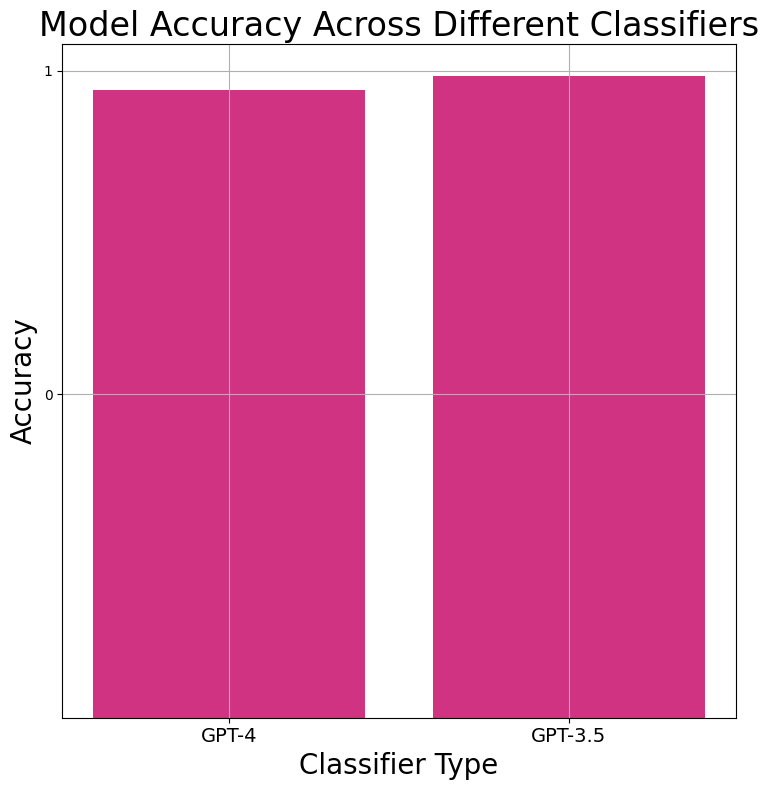

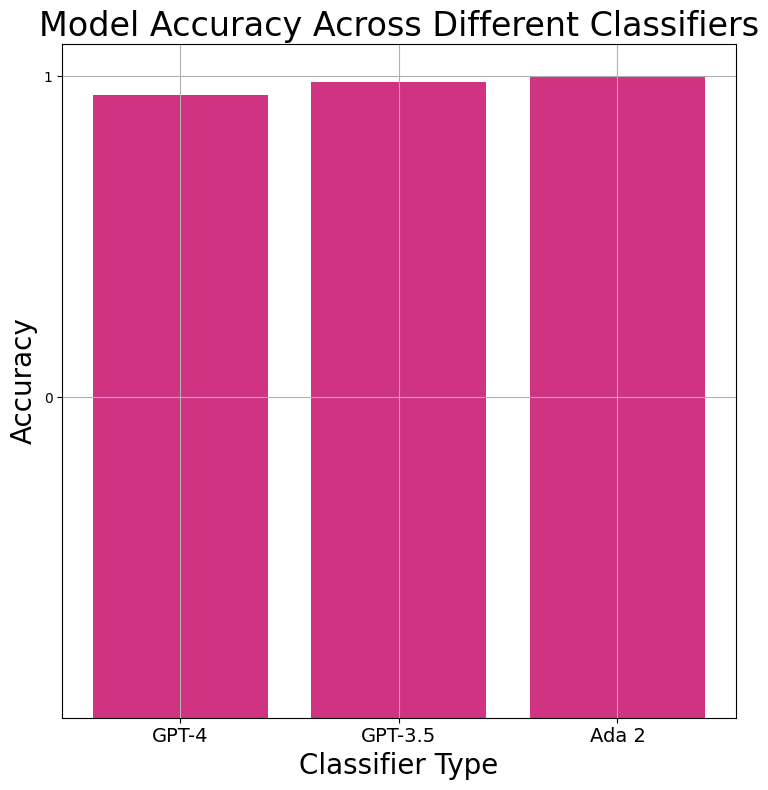

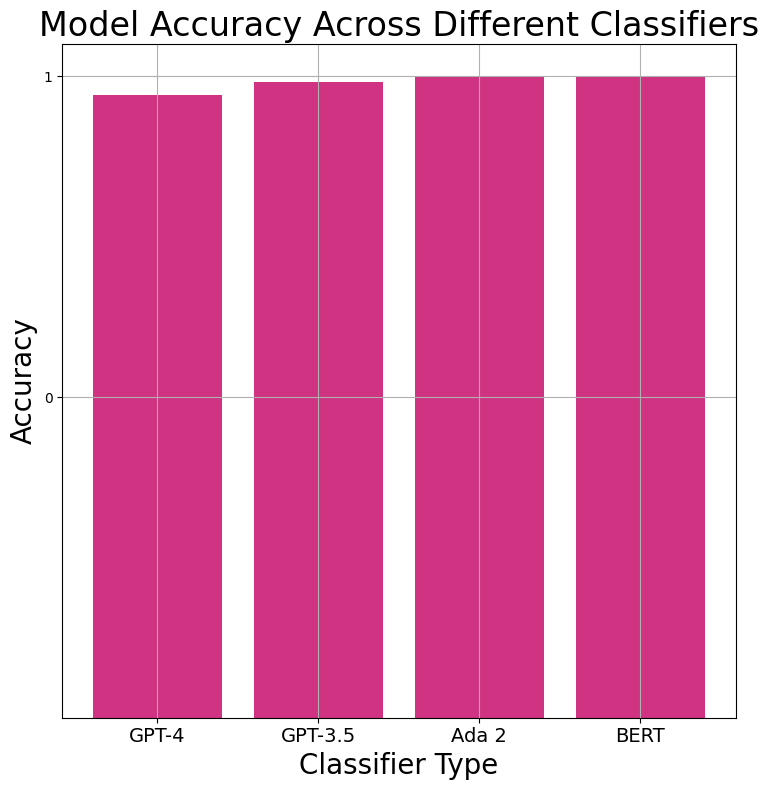

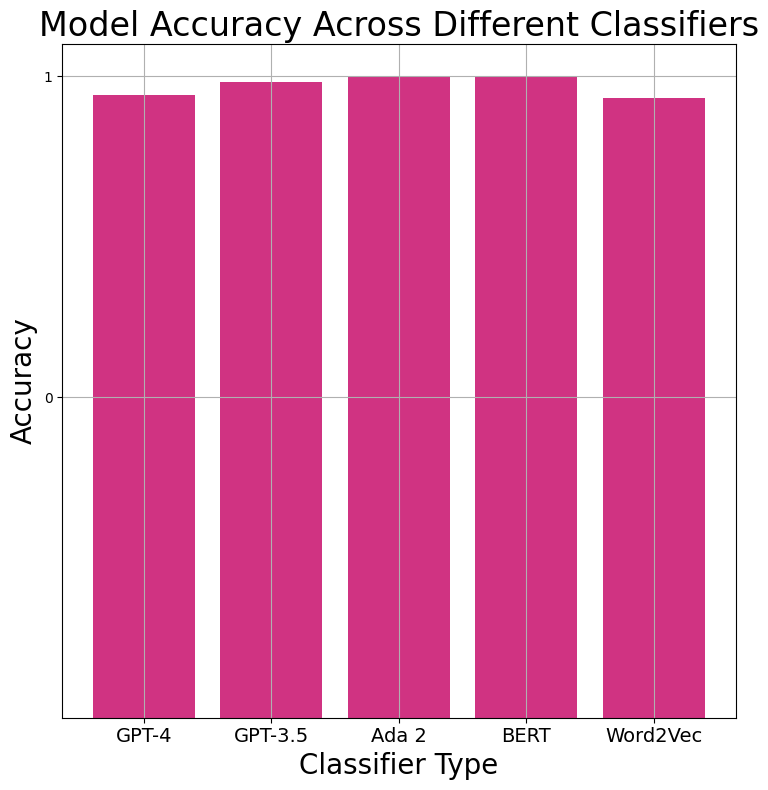

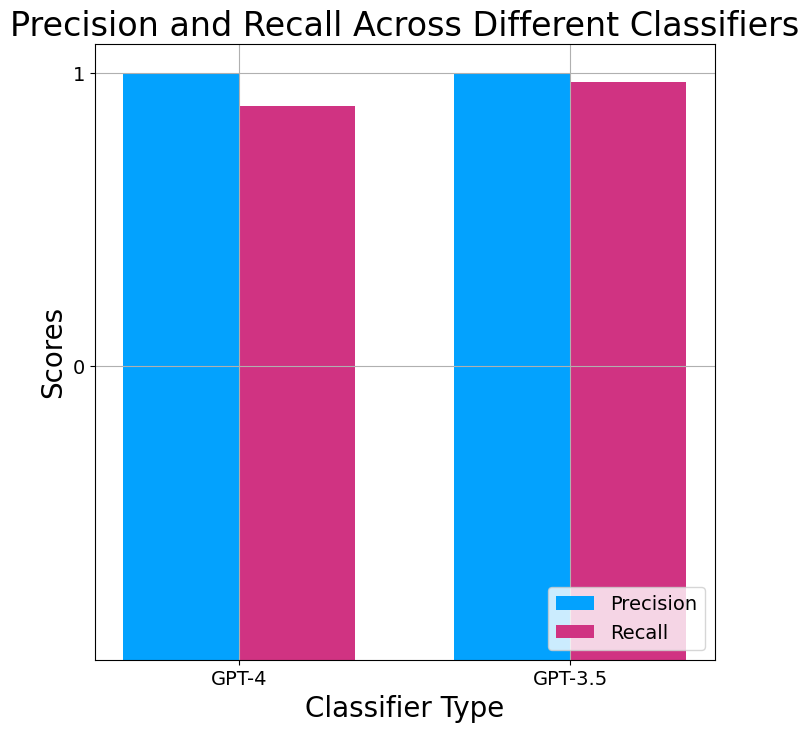

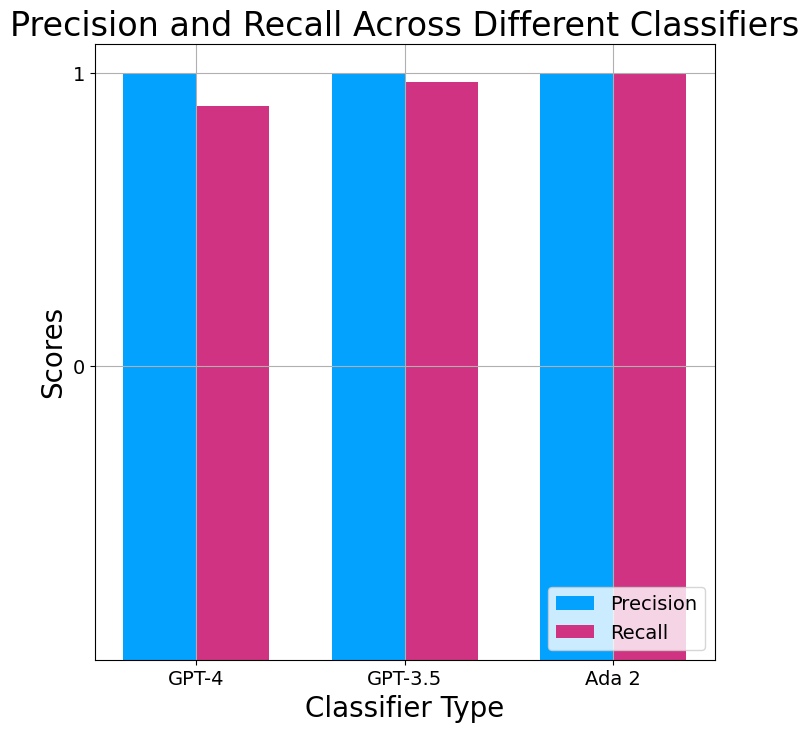

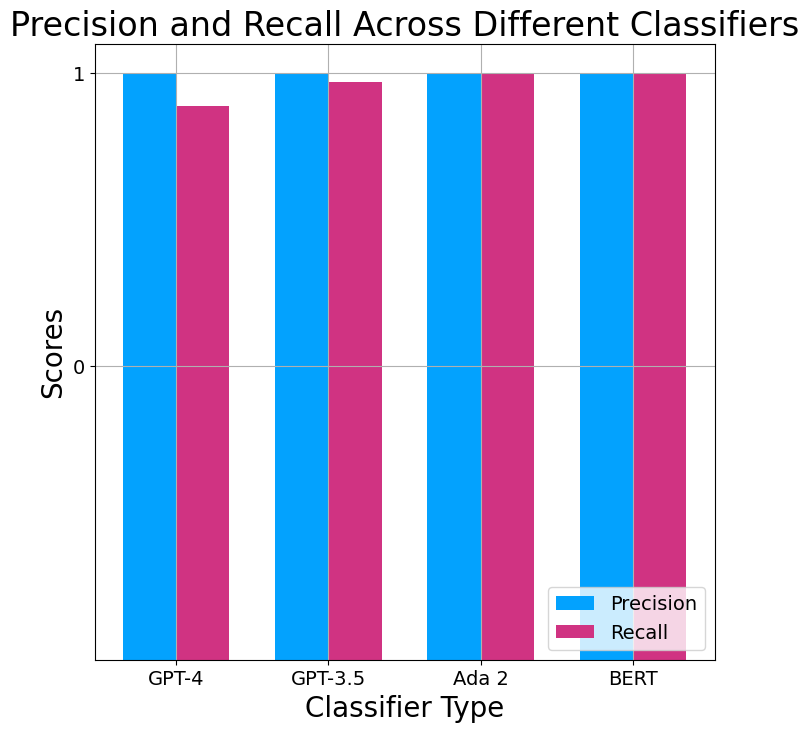

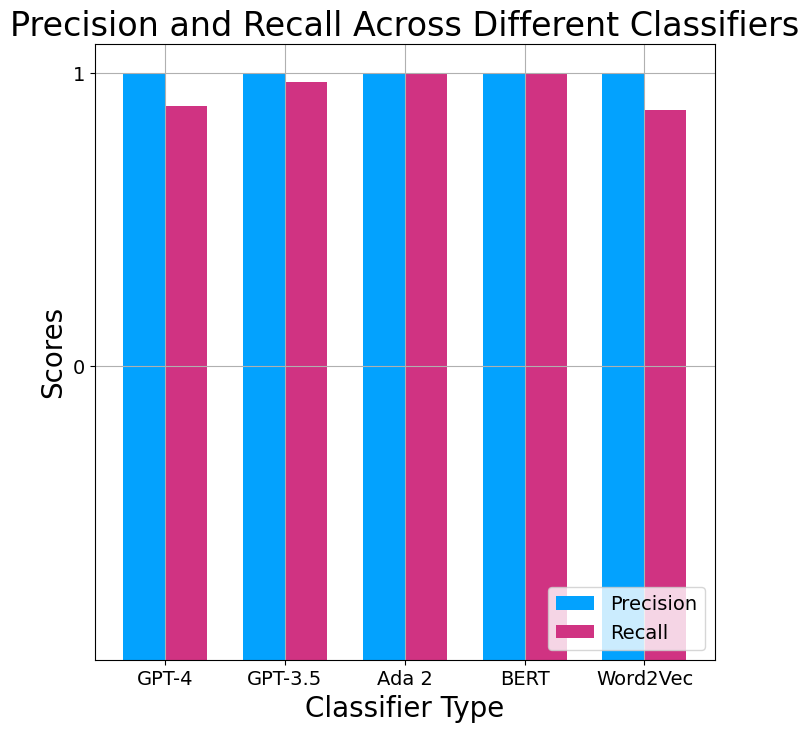

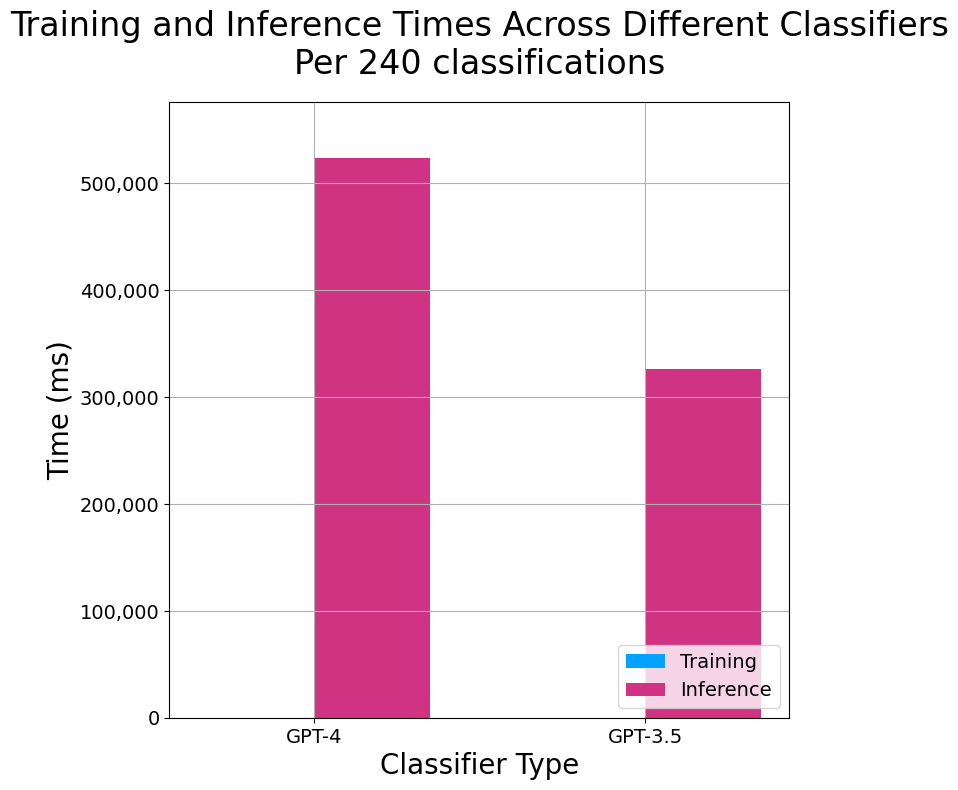

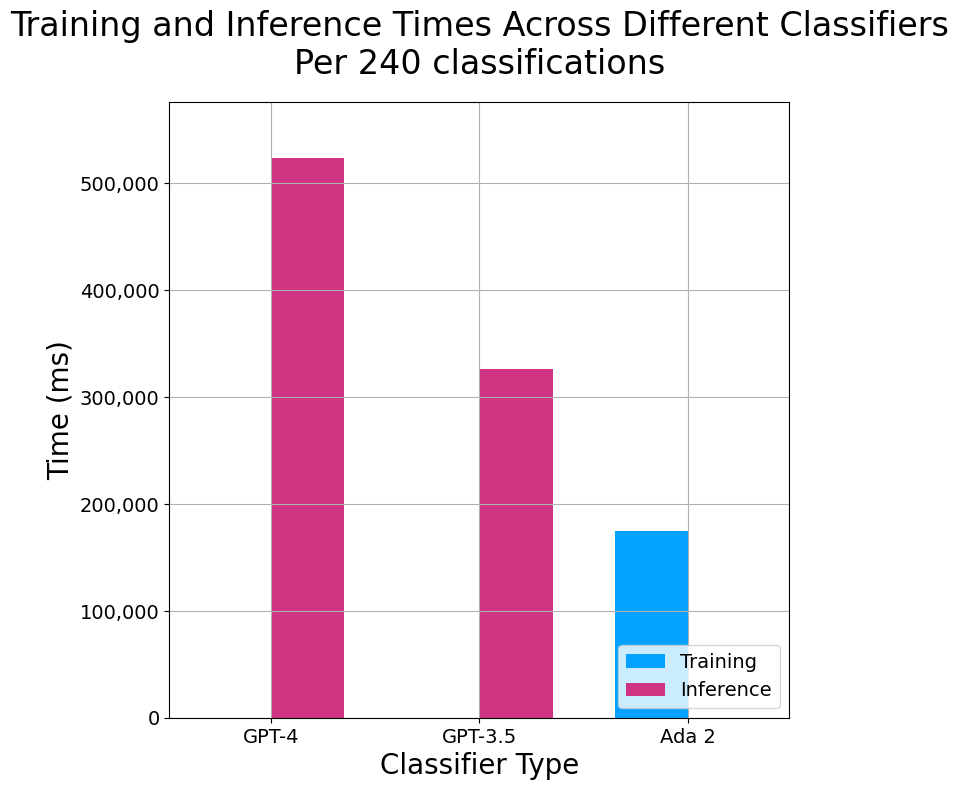

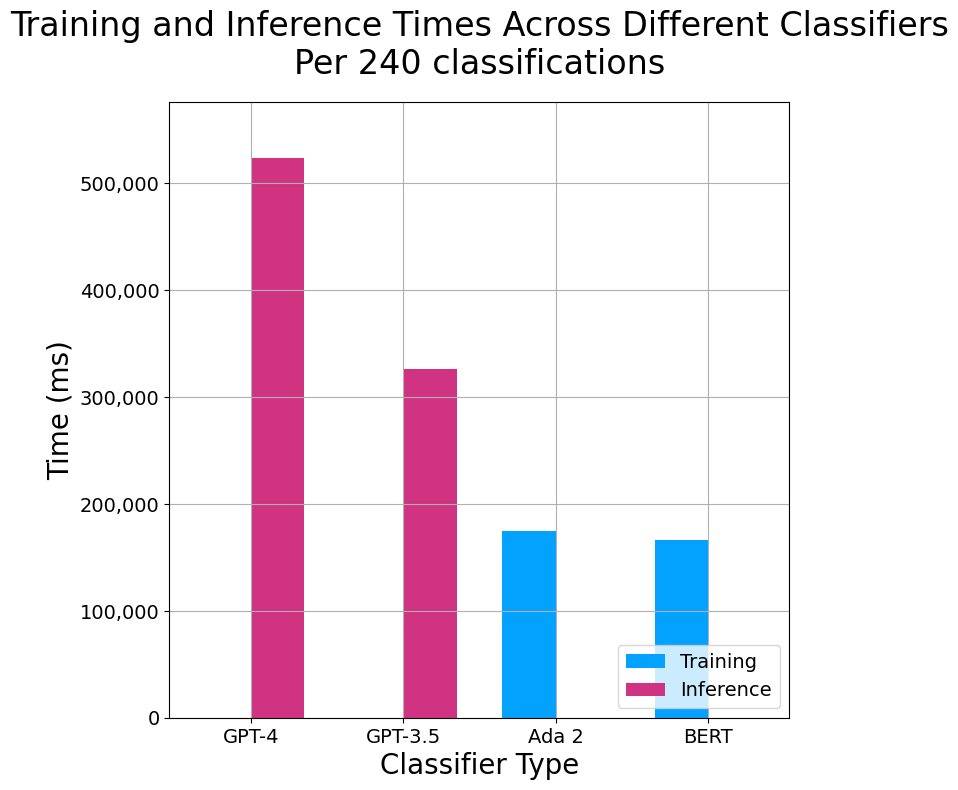

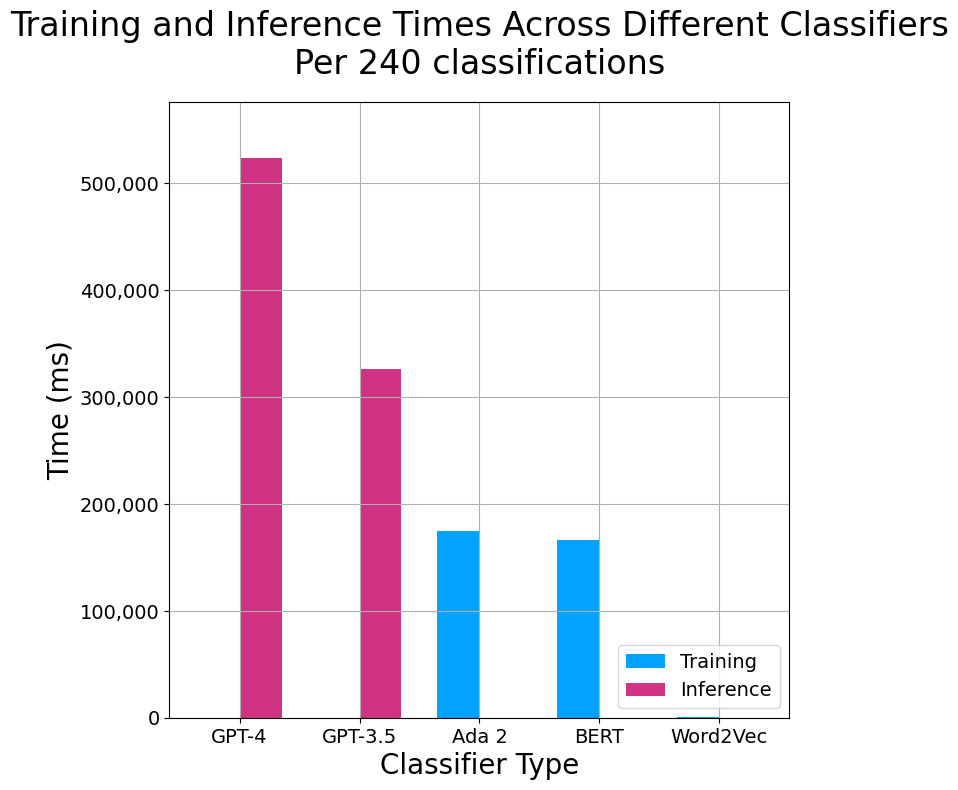

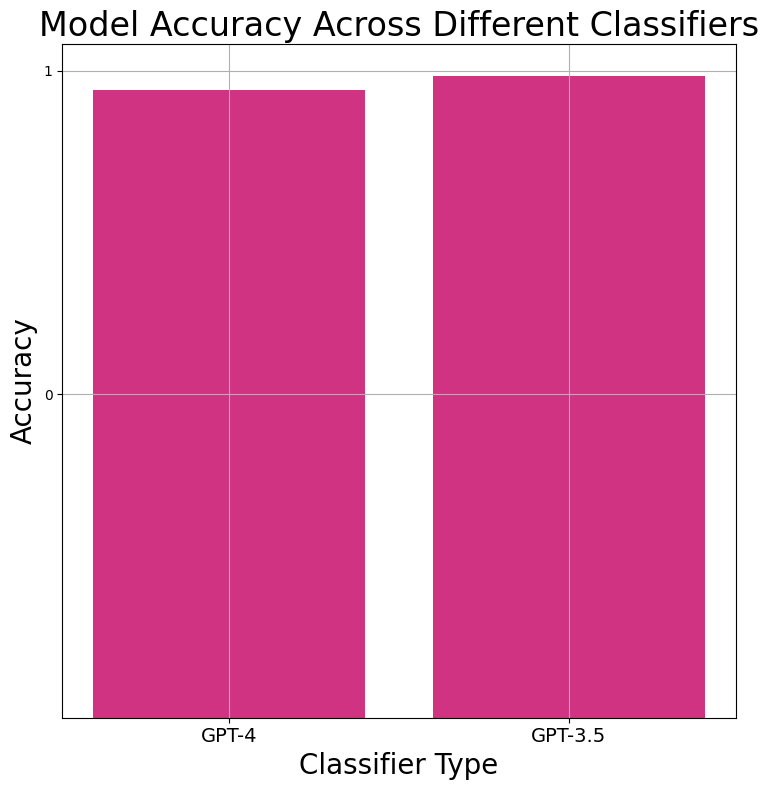

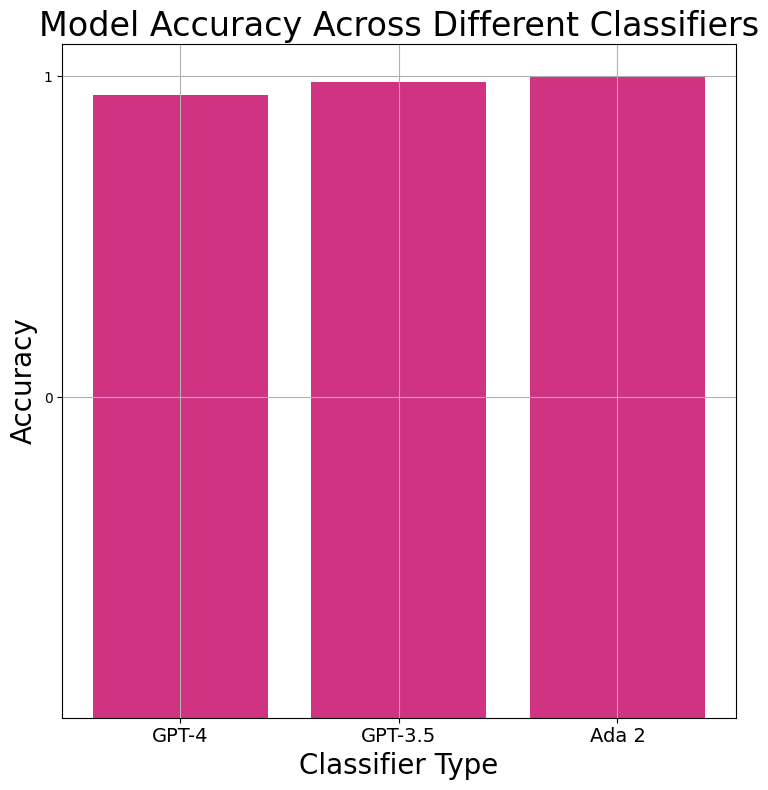

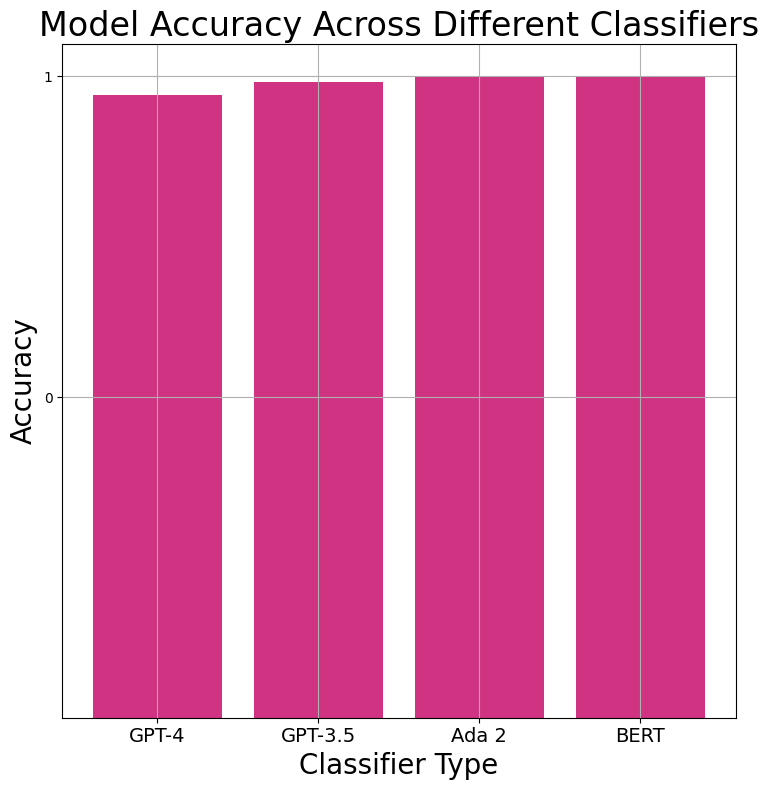

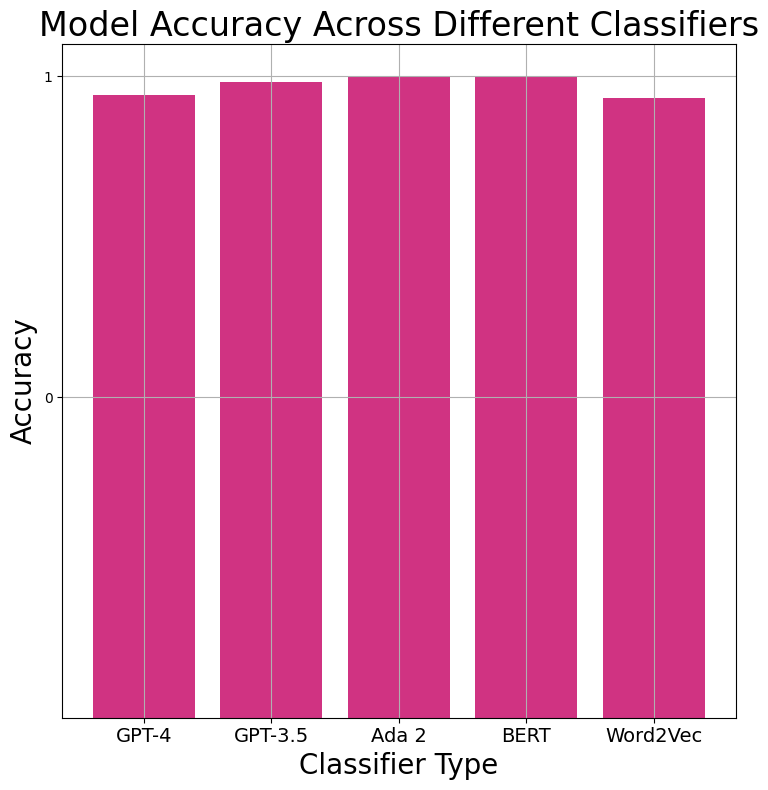

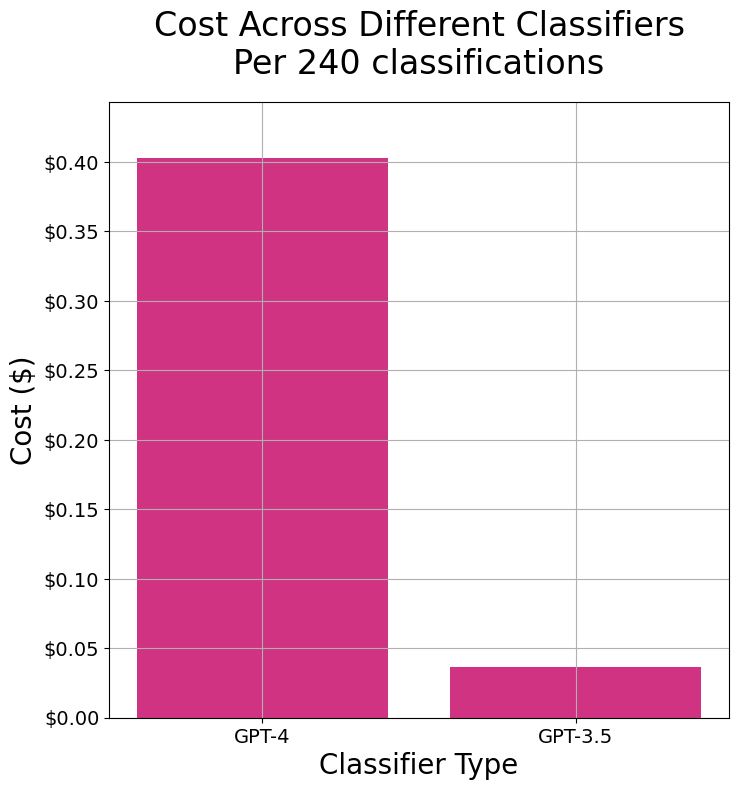

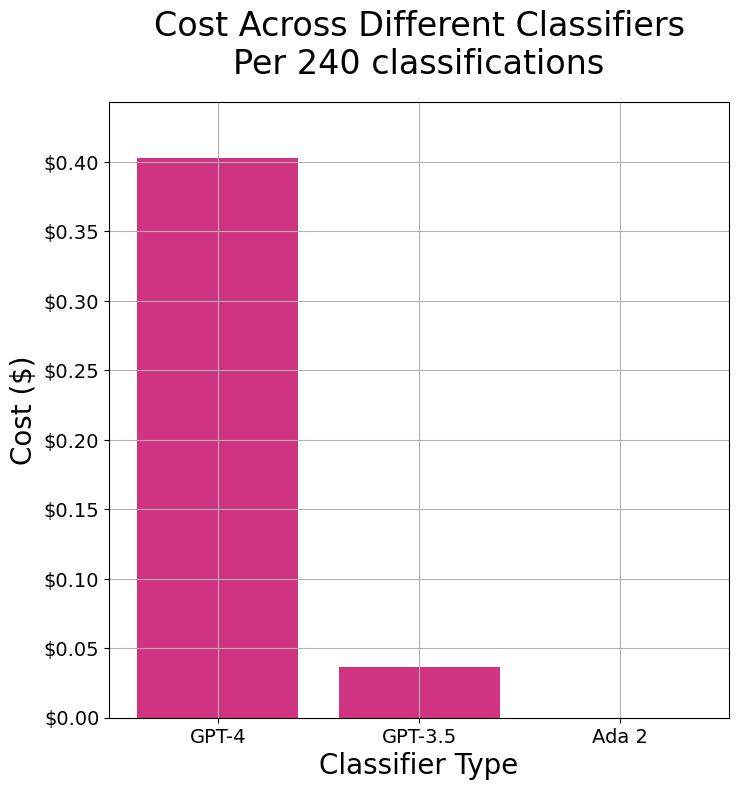

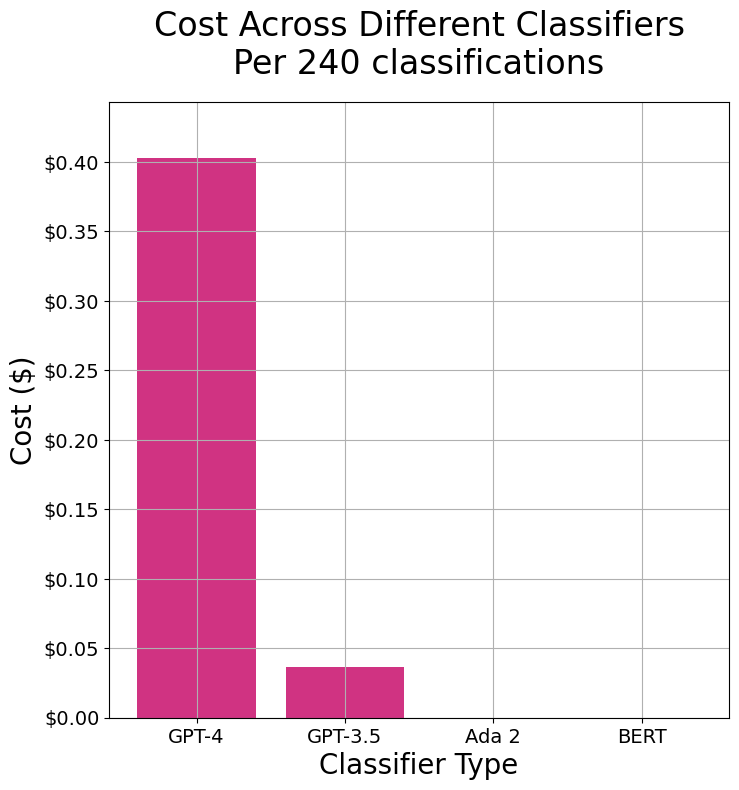

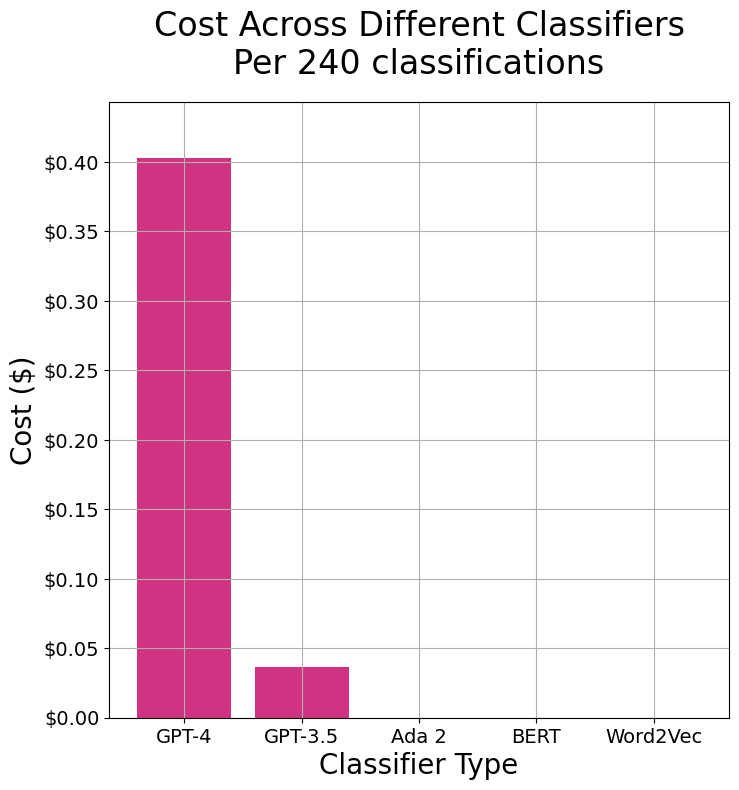

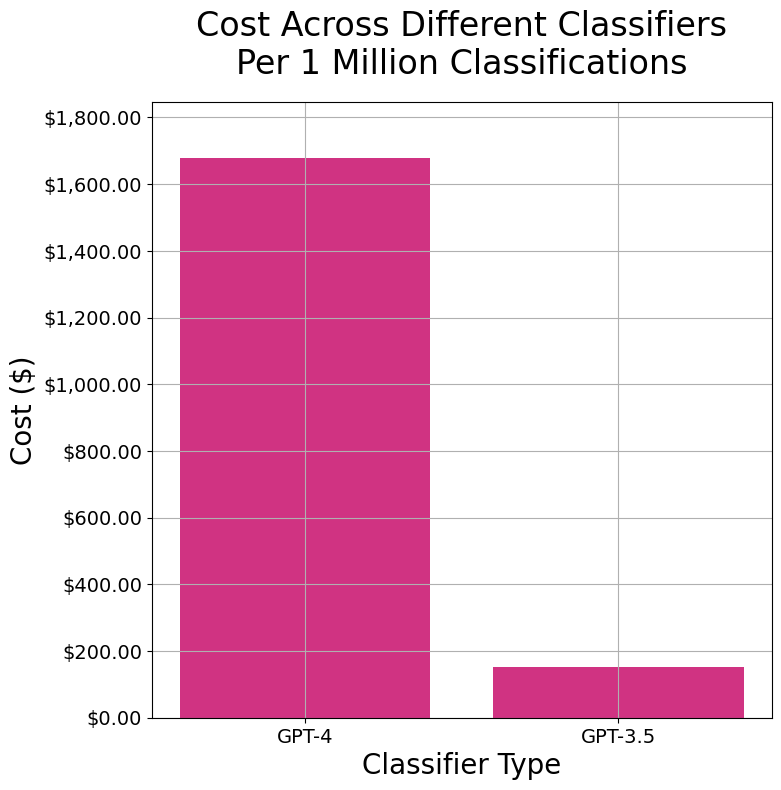

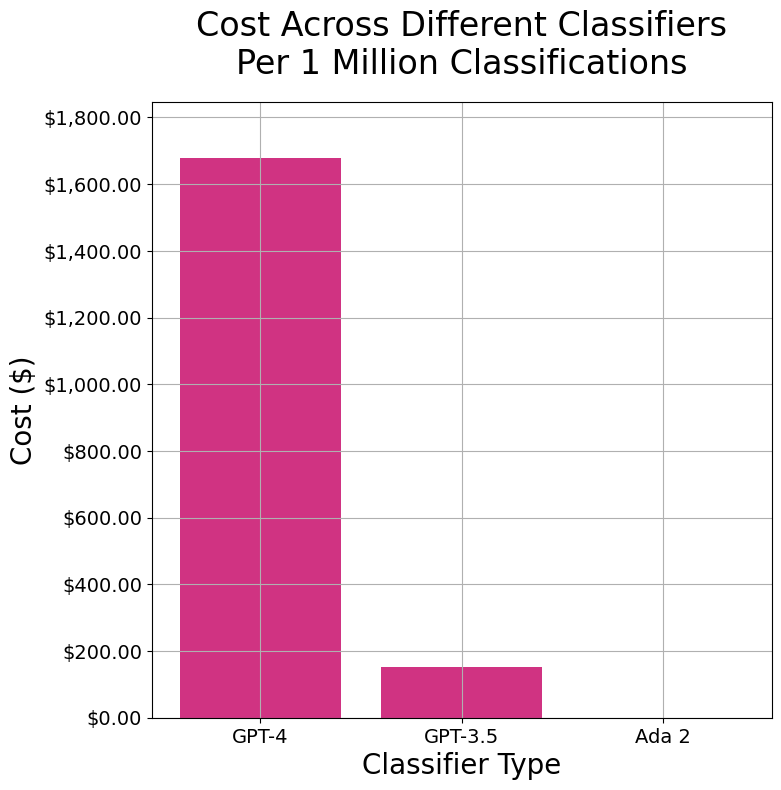

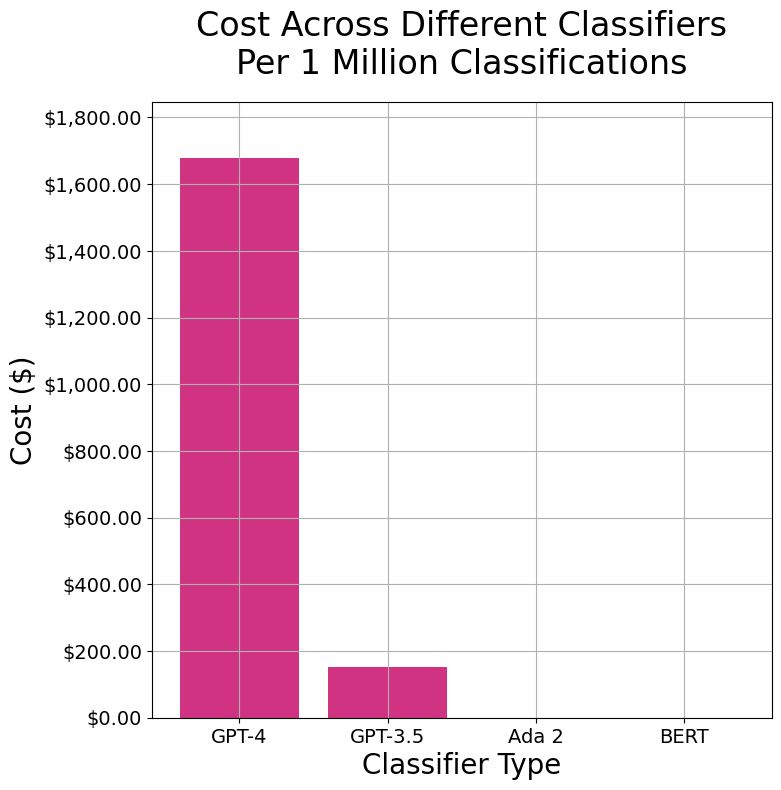

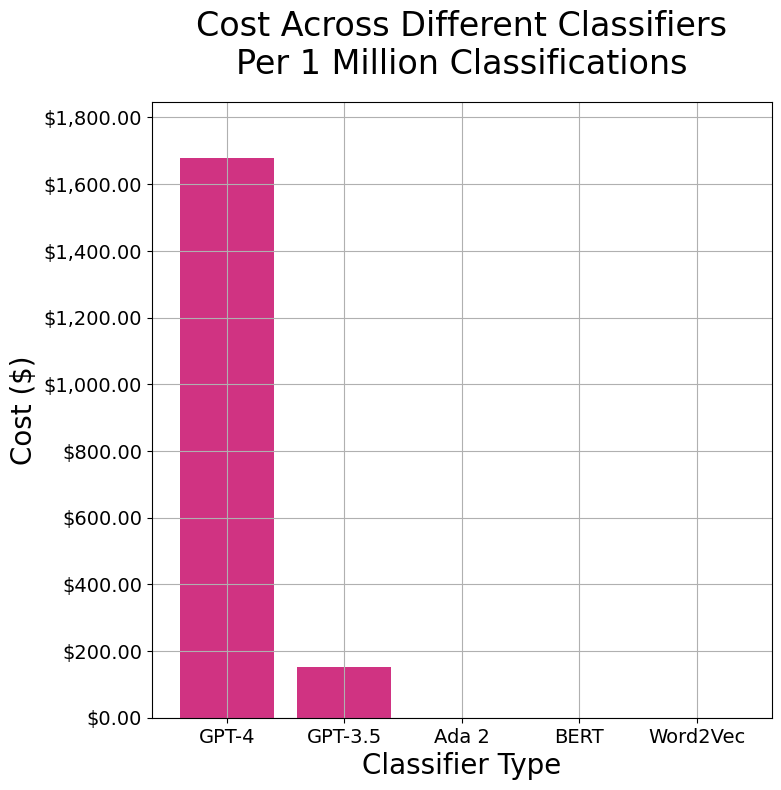

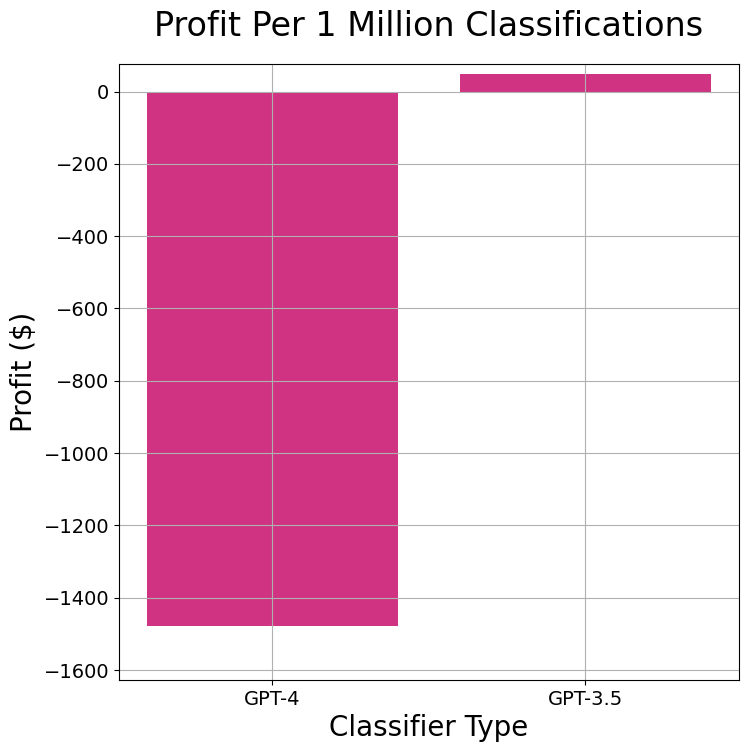

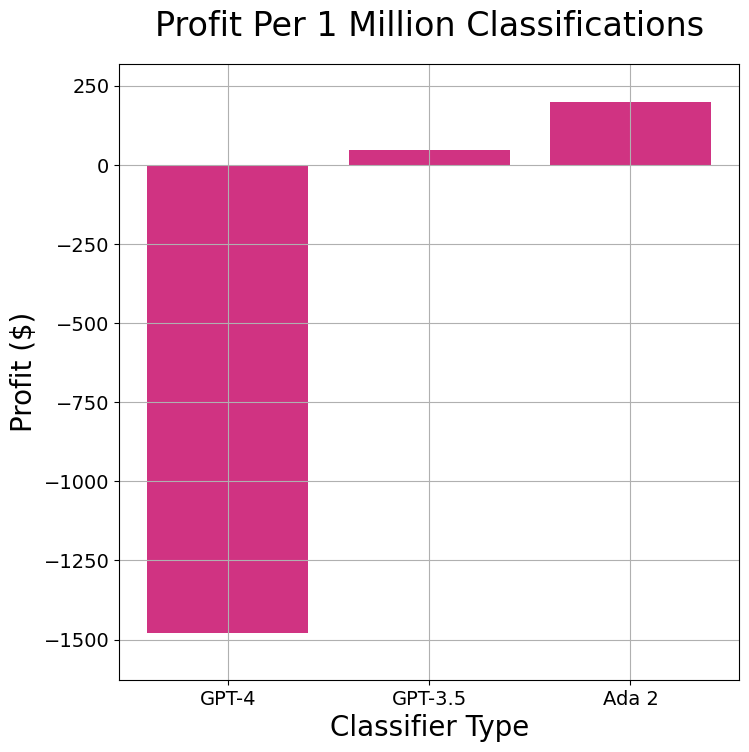

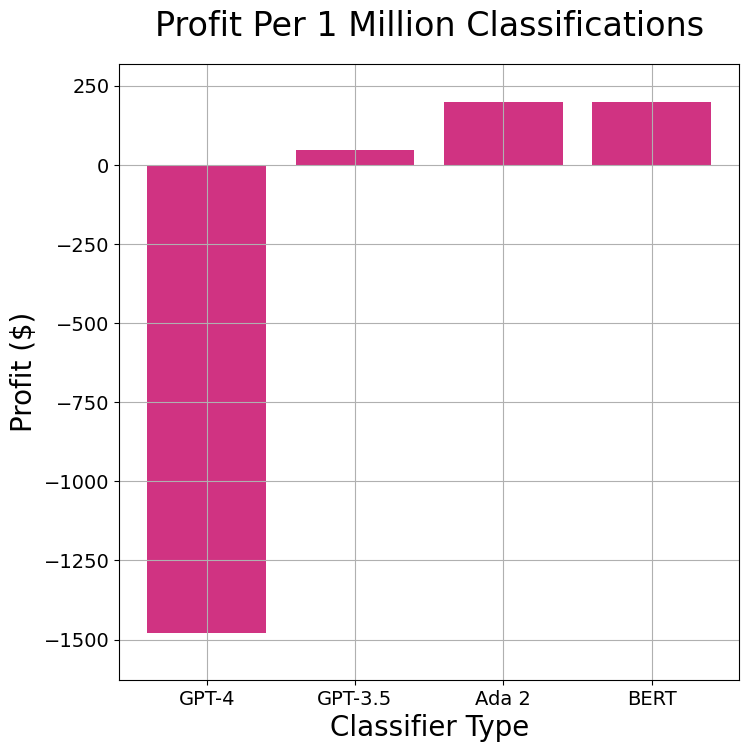

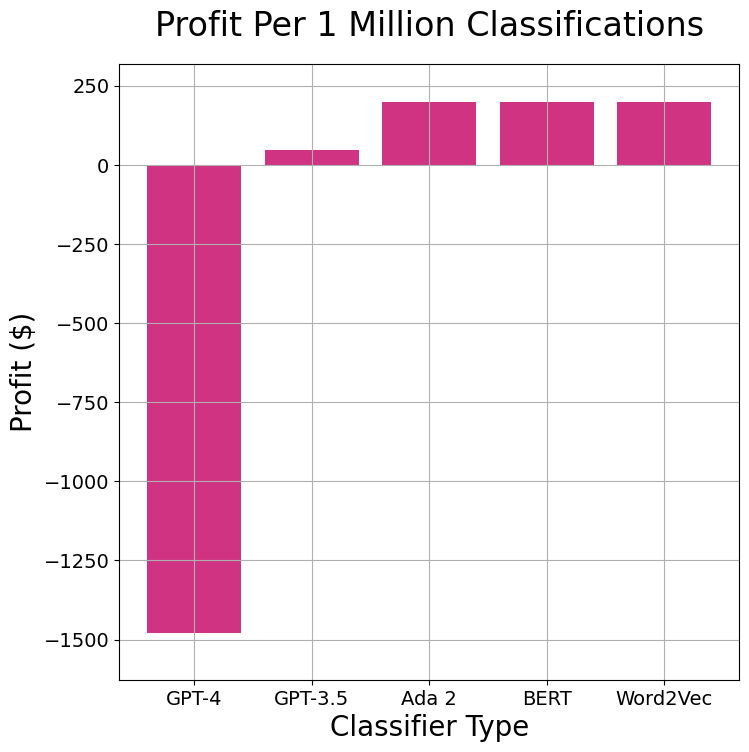

In [25]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format the tick labels with commas
def comma_formatter(x, pos):
    return '{:,}'.format(int(x))

# Remove '.csv' from filenames for plot labels
plot_labels = [filename.replace('.csv', '') for filename in all_series]

def generate_plot_filename(labels, descriptor):
    # Combines labels with a descriptor to create a filename
    label_str = '_'.join(labels).replace(' ', '_')
    return f"{descriptor}_{label_str}.png"

def plot_accuracy(labels, accuracies):
  # Metrics visualization
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.bar(labels, accuracies, color=(0.815, 0.2, 0.51), align='center')
  ax.set_xlabel('Classifier Type', fontsize=20)
  ax.set_ylabel('Accuracy', fontsize=20)
  ax.set_title('Model Accuracy Across Different Classifiers', fontsize=24)
  ax.set_xticks(range(len(labels)), labels, fontsize=14)
  ax.set_yticks([0.5, 1.0])
  ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
  ax.grid(True)

  # Force the aspect ratio of the axes box to be square
  ax.set_box_aspect(1)

  # Adjust subplots to fit the figure area
  fig.tight_layout()

  plt.savefig(generate_plot_filename(labels, 'accuracy'), bbox_inches='tight')

  plt.show()

plot_accuracy(plot_labels[0:2:1], accuracies[0:2:1])

plot_accuracy(plot_labels[0:3:1], accuracies[0:3:1])

plot_accuracy(plot_labels[0:4:1], accuracies[0:4:1])

plot_accuracy(plot_labels, accuracies)


def plot_precision_and_recall(labels, precisions, recalls):
  # Precision and Recall visualization
  fig, ax = plt.subplots(figsize=(8, 8))
  width = 0.35
  indices = np.arange(len(labels))

  # Using blue for precision and fuchsia for recall
  ax.bar(indices - width/2, precisions, width, label='Precision', color=(0.012, 0.635, 0.996))
  ax.bar(indices + width/2, recalls, width, label='Recall', color=(0.815, 0.2, 0.51))
  ax.set_xlabel('Classifier Type', fontsize=20)
  ax.set_ylabel('Scores', fontsize=20)
  ax.set_title('Precision and Recall Across Different Classifiers', fontsize=24)
  ax.set_yticks([0.5, 1.0])
  ax.set_xticks(range(len(labels)), labels, fontsize=14)
  ax.set_xticklabels(labels, fontsize=14)
  ax.tick_params(axis='y', labelsize=14)  # Set y-ticks font size
  ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
  ax.grid(True)

  # Move legend to the bottom
  # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
  plt.legend(loc='lower right', fontsize=14)

  plt.savefig(generate_plot_filename(labels, 'precision_recall'), bbox_inches='tight')

  plt.show()

plot_precision_and_recall(plot_labels[0:2:1], precisions[0:2:1], recalls[0:2:1])

plot_precision_and_recall(plot_labels[0:3:1], precisions[0:3:1], recalls[0:3:1])

plot_precision_and_recall(plot_labels[0:4:1], precisions[0:4:1], recalls[0:4:1])

plot_precision_and_recall(plot_labels, precisions, recalls)


def plot_time_and_training_time(labels, time, training_time):
    fig, ax = plt.subplots(figsize=(8, 8))
    width = 0.35
    indices = np.arange(len(labels))

    ax.bar(indices - width/2, training_time, width, label='Training', color=(0.012, 0.635, 0.996))
    ax.bar(indices + width/2, time, width, label='Inference', color=(0.815, 0.2, 0.51))
    ax.set_xlabel('Classifier Type', fontsize=20)
    ax.set_ylabel('Time (ms)', fontsize=20)
    ax.set_title('Training and Inference Times Across Different Classifiers\nPer 240 classifications', fontsize=24, pad=20)

    # Dynamically set the y-ticks based on the data
    max_value = max(max(training_time), max(time))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
    ax.set_ylim(0, max_value * 1.1)  # Set y-axis limit slightly higher than max value

    ax.set_xticks(indices)
    ax.set_xticklabels(labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    ax.grid(True)

    plt.legend(loc='lower right', fontsize=14)
    plt.savefig(generate_plot_filename(labels, 'time_training'), bbox_inches='tight')
    plt.show()

plot_time_and_training_time(plot_labels[0:2:1], times[0:2:1], training_times[0:2:1])

plot_time_and_training_time(plot_labels[0:3:1], times[0:3:1], training_times[0:3:1])

plot_time_and_training_time(plot_labels[0:4:1], times[0:4:1], training_times[0:4:1])

plot_time_and_training_time(plot_labels, times, training_times)


# Function to format the tick labels with currency symbol and commas
def currency_formatter(x, pos):
    return f'${x:,.2f}'

def plot_cost(labels, costs):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.bar(labels, costs, color=(0.815, 0.2, 0.51), align='center')
    ax.set_xlabel('Classifier Type', fontsize=20)
    ax.set_ylabel('Cost ($)', fontsize=20)
    ax.set_title('Cost Across Different Classifiers\nPer 240 classifications', fontsize=24, pad=20)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=14)

    # Set y-axis major formatter for currency
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    # Dynamically set the y-ticks based on the data
    max_cost = max(costs)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0, max_cost * 1.1)  # Set y-axis limit slightly higher than max value

    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

    plt.savefig(generate_plot_filename(labels, 'cost'), bbox_inches='tight')
    plt.show()

def plot_cost_per_million(labels, costs):
    scale_factor = 1_000_000 / 240  # Scaling from 240 to 1,000,000 classifications
    scaled_costs = [cost * scale_factor for cost in costs]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.bar(labels, scaled_costs, color=(0.815, 0.2, 0.51), align='center')
    ax.set_xlabel('Classifier Type', fontsize=20)
    ax.set_ylabel('Cost ($)', fontsize=20)
    ax.set_title('Cost Across Different Classifiers\nPer 1 Million Classifications', fontsize=24, pad=20)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=14)

    # Set y-axis major formatter for currency
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

    # Dynamically set the y-ticks based on the data
    max_cost = max(scaled_costs)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0, max_cost * 1.1)  # Set y-axis limit slightly higher than max value

    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

    plt.savefig(generate_plot_filename(labels, 'cost_per_million'), bbox_inches='tight')
    plt.show()

def plot_profit_per_million(labels, costs, break_even_point=200):
    scale_factor = 1_000_000 / 240  # Scaling from 240 to 1,000,000 classifications
    scaled_costs = [cost * scale_factor for cost in costs]
    profits = [break_even_point - cost for cost in scaled_costs]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.bar(labels, profits, color='green' if all(profit >= 0 for profit in profits) else (0.815, 0.2, 0.51), align='center')
    ax.set_xlabel('Classifier Type', fontsize=20)
    ax.set_ylabel('Profit ($)', fontsize=20)
    ax.set_title('Profit Per 1 Million Classifications', fontsize=24, pad=20)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=14)

    # Dynamically set the y-ticks based on the data
    max_profit = max(profits)
    min_profit = min(profits)
    upper_limit = max_profit + (0.6 * max_profit)
    ax.set_ylim(min(min_profit * 1.1, 0), upper_limit)  # Adjust y-axis limits

    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

    plt.savefig(generate_plot_filename(labels, 'profit_per_million'), bbox_inches='tight')
    plt.show()


plot_accuracy(plot_labels[0:2:1], accuracies[0:2:1])

plot_accuracy(plot_labels[0:3:1], accuracies[0:3:1])

plot_accuracy(plot_labels[0:4:1], accuracies[0:4:1])

plot_accuracy(plot_labels, accuracies)


plot_cost(plot_labels[0:2:1], costs[0:2:1])

plot_cost(plot_labels[0:3:1], costs[0:3:1])

plot_cost(plot_labels[0:4:1], costs[0:4:1])

plot_cost(plot_labels, costs)


plot_cost_per_million(plot_labels[0:2:1], costs[0:2:1])

plot_cost_per_million(plot_labels[0:3:1], costs[0:3:1])

plot_cost_per_million(plot_labels[0:4:1], costs[0:4:1])

plot_cost_per_million(plot_labels, costs)


plot_profit_per_million(plot_labels[0:2:1], costs[0:2:1])

plot_profit_per_million(plot_labels[0:3:1], costs[0:3:1])

plot_profit_per_million(plot_labels[0:4:1], costs[0:4:1])

plot_profit_per_million(plot_labels, costs)

## ROC curve analysis and visualization

In [ ]:
# ROC Curve visualization
plt.figure(figsize=(10, 6))

for filename, model in models.items():
    X_train, X_test, y_train, y_test = train_test_splits[filename]
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{filename.replace(".csv", "")} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve Comparison', fontsize=24)
plt.legend(loc='lower right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

## Visualize the Confusion Matrix

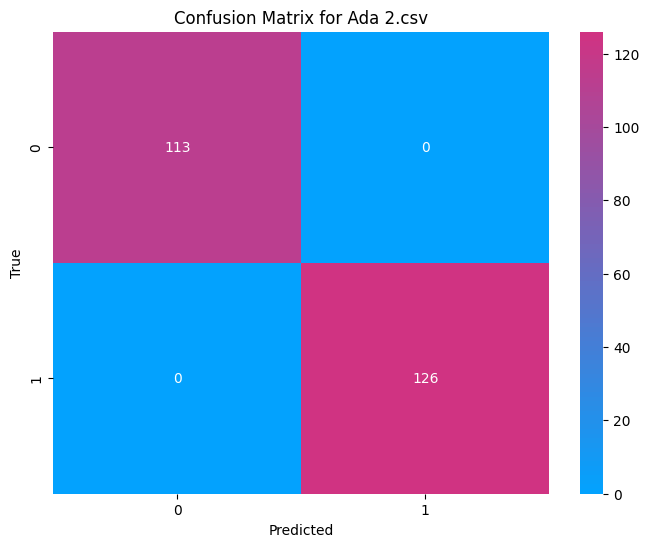

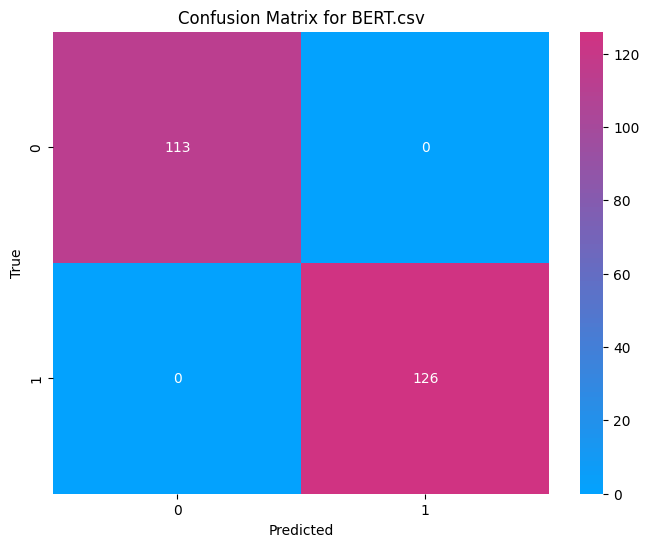

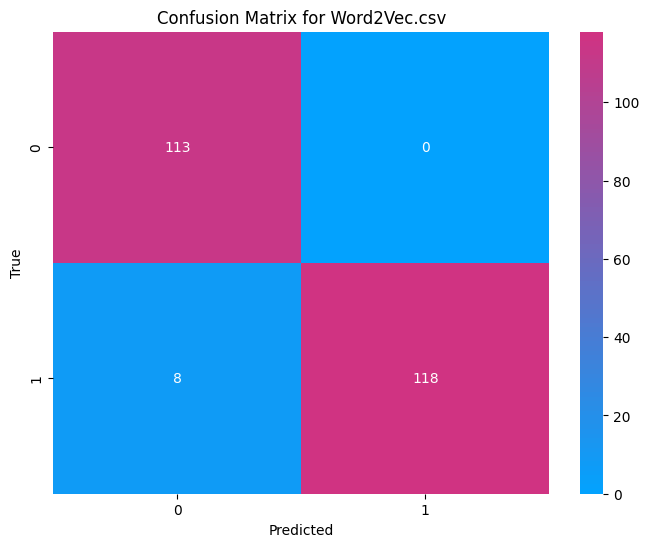

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Define custom colors for precision and recall
precision_color = (0.012, 0.635, 0.996)  # Blue
recall_color = (0.815, 0.2, 0.51)       # Red

# Create a custom colormap that smoothly transitions from precision to recall color
colors = [precision_color, recall_color]
n_bins = 100  # Number of color bins in the gradient
cmap_name = "custom_gradient_cmap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Iterate through the models and process actual data
for filename, model in models.items():
    X_train, X_test, y_train, y_test = train_test_splits[filename]

    # Predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualization with custom gradient colormap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap)
    plt.title(f"Confusion Matrix for {filename}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
